In [ ]:
"""
Created on 30/12/2024

@author: federica montana

Clean data and create dataframe to be used in 2_indicators_creation.ipynb

"""

# Import packages
import os
import pandas as pd
import geopandas as gpd
# Set environment variable
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import joblib

# Import custom utility functions
from utility import cities, cities2, new_name, clusters, statistics, london_cities

# Define the working directory
working_directory = os.getcwd()

In [26]:
## Create the boundary geodataframe for all the cities 

# Read the boundary of all the cities
# Loads a shapefile, renames columns, and applies custom processing.
gdf = gpd.read_file(os.path.join(working_directory, 'DATA', 'data0', 'cities.shp'))
gdf = gdf.rename(columns={'URAU_CODE': 'urau_code', 'URAU_NAME': 'urau_name'})  # Rename columns for consistency
gdf = cities(gdf)  # Apply custom function to the GeoDataFrame
gdf = cities2(gdf)  # Apply another custom function to the GeoDataFrame

# Read the boundary of greater cities
gdf2 = gpd.read_file(os.path.join(working_directory, 'DATA', 'data0', 'greater_cities.shp'))
gdf2.rename(columns={'URAU_CODE': 'urau_code', 'URAU_NAME': 'urau_name'}, inplace = True)  # Rename columns for consistency
# Select the London greater city
gdf_london = gdf2[gdf2.urau_code == 'UK001K2']

# Combine the boundaries of all cities and the London greater city
boundary = pd.concat([gdf, gdf_london])
boundary = gpd.GeoDataFrame(boundary, geometry='geometry')  # Ensure the combined DataFrame is a GeoDataFrame
boundary = new_name(boundary)  # Apply custom function to remove accents from city names
boundary = boundary[['urau_code','urau_name','geometry']]

# Save boundary to a new shapefile
boundary.to_file(os.path.join(working_directory, 'DATA', 'data', 'all_cities.shp'))

In [116]:
## Create population dataset

# Read population of the 917 cities
df_pop0 = pd.read_csv('DATA\\data0\grid_pop_weigthed.csv', sep=";", encoding= 'unicode_escape') 
# Convert column in numeric 
df_pop0['pop_final'] = df_pop0['pop_final'].str.replace(',', '.')
df_pop0['pop_final'] = pd.to_numeric(df_pop0['pop_final'])
df_pop0 = new_name(df_pop0)
# Exclude cities
df_pop01 = cities(df_pop0)
df_pop0 = cities2(df_pop01)

# Select only London greater city
df_pop_k = pd.read_csv('DATA\\\data0\hia_kgrid_pop.csv', sep=";", index_col=0)
df_pop_k['pop_final'] = df_pop_k['pop_final'].str.replace(',', '.')
df_pop_k['pop_final'] = pd.to_numeric(df_pop_k['pop_final'])
df_pop_k = df_pop_k[df_pop_k['urau_name']=='London']
df_pop_k0 = df_pop_k[['gid','urau_code','urau_name','pop_final']]

# Cities + LONDON
df_pop0 = pd.concat([df_pop0, df_pop_k0], axis=0)
del df_pop_k0
df_pop0['sum_pop'] = df_pop0.groupby('urau_code')['pop_final'].transform('sum')
df_pop = df_pop0[df_pop0.pop_final!=0]

# Log-transform the population
df_pop = df_pop.copy()
df_pop0 = df_pop0.copy()
df_pop0['pop_final_log'] = np.log1p(df_pop0['pop_final'])
df_pop['pop_final_log'] = np.log1p(df_pop['pop_final'])

# Divide in clusters
threshold1 = 1500000
threshold2 = 500000
threshold3 = 200000
threshold4 = 50000
df_pop0 = df_pop0.copy()
df_pop0['cluster']='small towns'

df_pop = df_pop.copy()
df_pop['cluster']='small towns'
# Assign cluster type based on population thresholds
# Large metropolitan: > 1,500,000
# Metropolitan: 500,000 - 1,500,000
# Medium: 200,000 - 500,000
# Small: 50,000 - 200,000
# Small towns: < 50,000
# Considering population dataset with grids = 0
df_pop0.loc[(df_pop0['sum_pop'] > threshold1), 'cluster'] = 'large metropolitan'
df_pop0.loc[(df_pop0['sum_pop'] > threshold2) & (df_pop0['sum_pop'] < threshold1), 'cluster'] = 'metropolitan'
df_pop0.loc[(df_pop0['sum_pop'] > threshold3) & (df_pop0['sum_pop'] < threshold2), 'cluster'] = 'medium'
df_pop0.loc[(df_pop0['sum_pop'] > threshold4) & (df_pop0['sum_pop'] < threshold3), 'cluster'] = 'small'

# Considering population dataset without grids != 0
df_pop.loc[(df_pop['sum_pop'] > threshold1), 'cluster'] = 'large metropolitan'
df_pop.loc[(df_pop['sum_pop'] > threshold2) & (df_pop['sum_pop'] < threshold1), 'cluster'] = 'metropolitan'
df_pop.loc[(df_pop['sum_pop'] > threshold3) & (df_pop['sum_pop'] < threshold2), 'cluster'] = 'medium'
df_pop.loc[(df_pop['sum_pop'] > threshold4) & (df_pop['sum_pop'] < threshold3), 'cluster'] = 'small'

# Save the population data to a new CSV file
df_pop0.to_csv(os.path.join(working_directory, 'DATA', 'data', 'grid_pop0.csv'), index=False)
df_pop.to_csv(os.path.join(working_directory, 'DATA', 'data', 'grid_pop.csv'), index=False)

In [41]:
## Create Figure S1b
# Load data
df_pop = pd.read_csv(os.path.join(working_directory, 'DATA', 'data', 'grid_pop.csv'))

# Define the desired order of clusters
cluster_order = clusters  # Adjust based on your cluster names

# Ensure the 'cluster' column is categorical with the desired order
df_pop['cluster'] = pd.Categorical(df_pop['cluster'], categories=cluster_order, ordered=True)

# Convert population to millions
df_pop['pop_final_millions'] = df_pop['pop_final'] / 1_000_000

# Create a bar plot showing population distribution by cluster
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_pop, 
    x='cluster', 
    y='pop_final_millions', 
    estimator='sum', 
    order=cluster_order,
    ci=None
)

# Customize plot
# plt.title('Population Distribution by Cluster (in Millions)', fontsize=18)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Population (Million people)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('plots/data/population_distribution_by_cluster.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.close()


C:\Users\fmontana\AppData\Local\Temp\ipykernel_10948\1874199361.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


In [118]:
# Create boxplot of population distribution by cluster type (Figure S1.3)
plt.figure(figsize=(12, 6))

# Create a list of data for each cluster type
data = [df_pop[df_pop['cluster'] == cluster]['pop_final_log'] for cluster in clusters]

plt.boxplot(data, labels=clusters)
plt.xticks(rotation=45)
plt.title('Population Distribution by Cluster Type')
plt.ylabel('Population (log scale)')
plt.tight_layout()
plt.savefig('plots/data\\population_distribution_by_cluster_type.png', dpi=300, bbox_inches='tight')
plt.close()

C:\Users\fmontana\AppData\Local\Temp\ipykernel_10948\3469387223.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=clusters)


In [12]:
## Create Geodataframe

# Read the grid geometry data of the 917 cities
gdf = gpd.read_file('DATA\\data0\gdf_pop.shp')
# Read population data
df_pop = pd.read_csv('DATA\\data\grid_pop.csv')
# Merge with population data and add the cluster column
gdf1 = pd.merge(gdf,df_pop[['gid','urau_code','cluster']], on=['gid','urau_code'], how='inner')
gdf1 = gpd.GeoDataFrame(gdf1, geometry='geometry')
gdf1.rename(columns={'urau_name_': 'urau_name'}, inplace=True)
gdf1.drop(columns=['urau_nam_1'], inplace=True)
# Save the GeoDataFrame to a new GeoJSON file
gdf1.to_file('DATA\\data\gdf_pop.geojson', driver='GeoJSON')

In [9]:
## Create Gedataframe for UHI 

# Read the geometry of all the 987 cities initially defined in Urban Audit 
gdf2 = gpd.read_file(os.path.join(working_directory, 'DATA', 'data0', 'grid_geometry.shp'))
#  Filter rows in gdf2 where 'urau_code' is in the london_cities list
london_cities_gdf = gdf2[gdf2['urau_code'].isin(london_cities)]
# Save the result to a file
london_cities_gdf.to_file('DATA\data\london_cities.gpkg', driver='GPKG')  # Save as GeoPackage


Urban Design

In [197]:
### Optimal dwelling density 
# Compute dwelling density

# Create the dwellings
# Steps:
# 1. Read population data from a CSV file.
df_pop = pd.read_csv(os.path.join(working_directory, 'DATA', 'data', 'grid_pop.csv'))

# 2. Create a 'code' column from the first two letters of 'urau_code'.
df_pop['code'] = df_pop['urau_code'].str[:2]

# 3. Read nation codes from another CSV file and merge with population data.
df_nation = pd.read_csv('DATA\\data0\codes_nation.csv')
nations  = df_nation.nation.tolist()

df_house_pop = df_pop.merge(df_nation[['code','nation']], on='code', how='inner')

# 4. Read household data from an Excel file and process it to get the average number of people per house.

d = pd.read_excel('DATA\\data0\household_spreadsheet.xlsx', sheet_name='Sheet 1',engine="openpyxl")
d = d.copy()
d = d[16:52]
dd = d[['Data extracted on 18/08/2023 16:51:58 from [ESTAT]','Unnamed: 19']]
dd = dd.copy()
dd.rename(columns={'Data extracted on 18/08/2023 16:51:58 from [ESTAT]': 'nation'}, inplace=True)
dd.rename(columns={'Unnamed: 19': 'person_per_house'}, inplace=True)

df_stat = dd.sort_values(by=['nation'], ascending=True)
df_stat = df_stat.loc[dd['nation'].isin(nations)]
df_stat.reset_index(drop=True, inplace=True)
df_stat['person_per_house'] = df_stat['person_per_house'].replace(':', 2.1) #Norway
#'England', 'Swiss', 'Island' are not present
new_rows = pd.DataFrame({'nation': ['England', 'Swiss', 'Island'], 'person_per_house':[2.36, 2.18, 2.5]})
df_stat = pd.concat([df_stat, new_rows], ignore_index=True)

# 5. Merge the processed household data with the population data.
df_dwelling = df_house_pop.merge(df_stat, on='nation', how='inner')

# 6. Calculate the number of dwellings and dwellings per hectare.
df_dwelling['dwellings'] = pd.to_numeric(df_dwelling['pop_final']/df_dwelling['person_per_house']) #number of housing 
area_grid_ha = 6.25 #1 meter square = 0,0001 hectar
df_dwelling['dwellings_per_ha'] = df_dwelling['dwellings']/area_grid_ha 

# 7. Apply a logarithmic transformation to the dwellings per hectare.
df_dwelling['dwellings_per_ha_log'] = np.log1p(df_dwelling['dwellings_per_ha'])

# 8. Select only the necessary columns.
df_dwelling = df_dwelling[['gid', 'pop_final', 'urau_code', 'urau_name', 'cluster', 'dwellings_per_ha_log','person_per_house']]
# Rename the 'dwellings_per_ha_log' column to 'val'
df_dwelling.rename(columns={'dwellings_per_ha_log': 'val_grid'}, inplace=True)

# 9. Save the dwelling data to a new CSV file.
df_dwelling.to_csv(os.path.join(working_directory, 'DATA', 'data', 'val_grid.csv'), index=False)
df_dwelling.to_csv('DATA\\data\\df_dwellings.csv', index=False)


C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
### Mid rise development data

# Read the data
df = pd.read_csv(os.path.join(working_directory, 'DATA', 'data0', 'gid_lcz.csv'), index_col=0).sort_values(by=['gid'], ascending=True)

# Apply custom functions to the DataFrame
df = cities(df)
df = cities2(df)

# Remove all the cities with 'K' as the penultimate letter except for the city of London
df = df[~(df['urau_code'].apply(lambda x: x[-2] == 'K') & (df['urau_code'] != 'UK001K2'))]

# Merge with population data
df_pop = pd.read_csv('DATA\\data\\grid_pop.csv')
df = pd.merge(df, df_pop[['gid', 'urau_code', 'urau_name','cluster']], on=['gid', 'urau_code'], how='right')

# Create the lowmid column which is the sum of all the low-rise and mid-rise entries
lowmid_columns = df.filter(regex=('lowrise|midrise')).columns.tolist()
df['val_grid'] = df[lowmid_columns].sum(axis=1) * 100

# Select only the necessary columns.
df2 = df[['gid', 'pop_final', 'urau_code', 'urau_name', 'cluster', 'val_grid']]

# Save the result to a new CSV file
df2.to_csv('DATA\\data\\df_lcz.csv', index=False)


In [15]:
# Calculate the statistics of the compact midrise, compact lowrise, open midrise, open lowrise, and large lowrise 
columns = ['compact_midrise', 'compact_lowrise', 'open_midrise', 
           'open_lowrise', 'large_lowrise']
names = ['Compact Midrise', 'Compact Lowrise', 'Open Midrise', 
           'Open Lowrise', 'Large Lowrise']
d = statistics(df, columns[0], names[0])

In [16]:
### Permeability data

# Read permeability data for cities
df_imd = pd.read_csv('DATA\\data0\\grids_imd_totalarea_grid_pop.csv').sort_values(by=['gid'], ascending=True)
df_imd = cities(df_imd)  # Apply custom function to the DataFrame
df_imd = cities2(df_imd)  # Apply another custom function to the DataFrame

# Read permeability data for London
dfk_imd = pd.read_csv('DATA\\data0\\grids_imd_totalarea_kgrid_pop.csv').sort_values(by=['gid'], ascending=True)
df_london_imd = dfk_imd[dfk_imd.urau_code == 'UK001K2']  # Select only London data

# Combine permeability data for cities and London
df_imd = pd.concat([df_imd, df_london_imd], axis=0)
del df_london_imd  # Delete the temporary London data

# Merge permeability data with population data
df_imd2 = pd.merge(df_imd, df_pop, on=['gid', 'urau_code'], how='right')
df_imd2.to_csv('DATA\\data\\df_imd.csv', index=False)  # Save the merged data to a CSV file

# Compute the percentage of permeability
area = 250 * 250  # Define the area
df_imd2['per_permeability'] = (df_imd2.non_sealed / area) * 100  # Calculate permeability percentage
# Select only the necessary columns.
df_imd2 = df_imd2[['gid', 'pop_final', 'urau_code', 'urau_name', 'cluster', 'per_permeability']]
df_imd2.rename(columns={'per_permeability': 'val_grid'}, inplace=True)  # Rename the 'per_permeability' column to 'val'

# Save the final result to a new CSV file
df_imd2.to_csv('DATA\\data\\df_imd.csv', index=False)


In [18]:
# Create boxplot of permeability distribution by cluster type
name = 'Permeability'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
df = df_imd2.copy()
# Sort by cluster
df['cluster'] = pd.Categorical(df['cluster'], categories=clusters, ordered=True)

# Sort the DataFrame by the 'cluster' column
df = df.sort_values(by='cluster')
# Plot boxplot
sns.boxplot(data=df, x='cluster', y='val_grid', ax=ax1)
#df.boxplot(column = val, by='cluster',ax=ax1) 
ax1.set_title(f'{name} Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel(f'{name} (%)')
ax1.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'PLOTS\\data\\{name}.png')
# Show the plot
plt.close()

Sustainable Transportation

In [3]:
### Walkability and Cyclability data

# Define the path to the OSM data for cities
osm_path = "DATA\\data0\\hia_osm_roadlength_connectivity_grid_pop.csv"
# Read the OSM data for cities
osm_cities = pd.read_csv(osm_path, sep=",")
# Apply custom functions to the DataFrame to remove cities not considered in the study
osm_cities = cities(osm_cities)
osm_cities = cities2(osm_cities)

# Define the path to the OSM data for greater cities
osm_path = "DATA\\data0\\hia_osm_roadlength_connectivity_kgrid_pop.csv"
# Read the OSM data for greater cities
osm_gcities = pd.read_csv(osm_path, sep=",")
# Select only London data
osm_gcities = osm_gcities[osm_gcities['urau_code'] == 'UK001K2']

# Combine OSM data for cities and London greater city
osm = pd.concat([osm_cities, osm_gcities])
osm = osm.sort_values(by=["urau_code", "gid"])

# Select OSM variables of interest for the analysis
osm = osm[["gid", "urau_code", 'total_roadlength', "primary", "primary_link", "secondary", "secondary_link",
           "tertiary", "tertiary_link", "unclassified", "residential", "living_street", "pedestrian", "footway", 
           'steps', 'path', "track", "cycleway"]]

# Convert footway column to numeric and fill NaN values with 0
osm["footway"] = pd.to_numeric(osm["footway"], errors="coerce")
osm.fillna(0, inplace=True)

# Combine primary and primary_link streets
osm["primary"] = osm["primary"] + osm["primary_link"]
# Combine secondary and secondary_link streets
osm["secondary"] = osm["secondary"] + osm["secondary_link"]
# Combine tertiary and tertiary_link streets
osm["tertiary"] = osm["tertiary"] + osm["tertiary_link"]
# Combine unclassified and residential streets
osm["residential"] = osm["unclassified"] + osm["residential"]
# Combine unclassified, residential, and living_street streets
osm["residential_sum"] = osm["unclassified"] + osm["residential"] + osm["living_street"]

# Calculate pedestrian density using the definition of clean cities
osm["pedestrian_cc"] = osm["pedestrian"] + osm["living_street"] + osm["path"] + osm["footway"] + osm["steps"]

# Calculate total road length
osm['total_roadlength'] = osm["primary"] + osm["secondary"] + osm["tertiary"] + osm["residential"] + osm["pedestrian_cc"] + osm["cycleway"]

# Select indicators for analysis
osm_final = osm[["gid", "urau_code", 'pedestrian', 'pedestrian_cc', 'living_street', 'path', 
                 'footway', 'steps', 'cycleway', 'total_roadlength']]
aux = osm_final.describe()

# Identify outlier limit values
road = osm_final.total_roadlength.quantile(0.995)
ped = osm_final.pedestrian.quantile(0.995)
pedcc = osm_final.pedestrian_cc.quantile(0.995)
cycl = osm_final.cycleway.quantile(0.995)
living_street = osm_final.living_street.quantile(0.995)
path = osm_final.path.quantile(0.995)
footway = osm_final.footway.quantile(0.995)
steps = osm_final.steps.quantile(0.995)

# Substitute values above the limit with the maximum
osm_final = osm_final.copy()
osm_final = osm_final[osm_final["total_roadlength"] <= road]
osm_final = osm_final[osm_final["pedestrian"] <= ped]
osm_final = osm_final[osm_final["pedestrian_cc"] <= pedcc]
osm_final = osm_final[osm_final["cycleway"] <= cycl]
osm_final = osm_final[osm_final["path"] <= path]
osm_final = osm_final[osm_final["living_street"] <= living_street]
osm_final = osm_final[osm_final["footway"] <= footway]
osm_final = osm_final[osm_final["steps"] <= steps]

# Calculate pedestrian density percentage
osm = osm_final.copy()
osm['pedestrian_cc_per'] = np.where(
    osm['total_roadlength'] > 0,
    (osm['pedestrian_cc'] / osm['total_roadlength']) * 100,
    0
)
osm['pedestrian_per'] = np.where(
    osm['total_roadlength'] > 0,
    (osm['pedestrian'] / osm['total_roadlength']) * 100,
    0
)

# Calculate cycling density percentage
osm['cycleway_per'] = np.where(
    osm['total_roadlength'] > 0,
    (osm['cycleway'] / osm['total_roadlength']) * 100,
    0
)

# Merge with population data and export the final data
df_pop = pd.read_csv('DATA\\data\\grid_pop.csv')
osm_final = pd.merge(df_pop, osm, on=['gid', 'urau_code'], how='inner')
osm_final.to_csv('DATA\\data\\df_osm.csv', index=False)

# Select walk df
osm_walk = osm_final[['gid', 'urau_code', 'urau_name','pop_final', 'cluster', 'pedestrian_cc_per']]
osm_walk.rename(columns={'pedestrian_cc_per': 'val_grid'}, inplace=True)
osm_walk.to_csv('DATA\\data\\df_walk.csv', index=False)
# Select cycle df
osm_cycle = osm_final.copy()
osm_cycle.rename(columns={'cycleway_per': 'val_grid'}, inplace=True)
osm_cycle[['gid', 'urau_code', 'urau_name', 'pop_final','cluster', 'val_grid']]
osm_cycle.to_csv('DATA\\data\\df_cycl.csv', index=False)


C:\Users\fmontana\AppData\Local\Temp\ipykernel_11492\2650464237.py:6: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_cities = pd.read_csv(osm_path, sep=",")
C:\Users\fmontana\AppData\Local\Temp\ipykernel_11492\2650464237.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osm_walk.rename(columns={'pedestrian_cc_per': 'val_grid'}, inplace=True)


In [9]:
osm_final['pedestrian_cc_per'].describe()

count    784042.000000
mean         24.619497
std          27.654735
min           0.000000
25%           0.000000
50%          14.525691
75%          43.577618
max         100.000000
Name: pedestrian_cc_per, dtype: float64

In [4]:
# Summarize data for each cluster
osm = osm_final.copy()
osm_sum = osm.groupby(["urau_code", "cluster"], as_index = False)[ 'pedestrian_cc', 'cycleway', 'total_roadlength'].mean()
osm_city = osm.groupby(["urau_code"], as_index = False)[ 'pedestrian_cc', 'cycleway', 'total_roadlength'].mean()
cols_to_check = ['pedestrian_cc', 'cycleway', 'total_roadlength']
osm_sum.urau_code.nunique() # 917 cities

C:\Users\fmontana\AppData\Local\Temp\ipykernel_11492\639401237.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  osm_sum = osm.groupby(["urau_code", "cluster"], as_index = False)[ 'pedestrian_cc', 'cycleway', 'total_roadlength'].mean()
C:\Users\fmontana\AppData\Local\Temp\ipykernel_11492\639401237.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  osm_city = osm.groupby(["urau_code"], as_index = False)[ 'pedestrian_cc', 'cycleway', 'total_roadlength'].mean()


917

In [21]:
# Step 1: Group by 'urau_code' and check if all cycleway_per values are zero
df =osm_final.copy()
zero_groups = df.groupby('urau_code').filter(lambda x: (x['cycleway'] == 0).all())

# Step 2: Get unique `urau_code` values with all cycleway_per zero
zero_urau_codes = zero_groups['urau_code'].unique()

# Filter the GeoDataFrame to get the city names
city_names = df_pop[df_pop['urau_code'].isin(zero_urau_codes)][['urau_code', 'urau_name']]
city_names.drop_duplicates(subset=['urau_code'], inplace=True)
names = city_names.urau_code.to_list()
len(names)

36

In [187]:
### Public Transport stop

# Read the public transport data already cleaned such that the 99.5th percentile of the 'pubtrans', which coresponds to 20, is used as the upper limit
df = pd.read_csv('DATA\\data0\gid_osm_pubtrans_clean.csv').sort_values(by=['gid'], ascending=True)

df = cities(df)
df = cities2(df)

# Remove all the cities with 'K' as the penultimate letter except for the city of London
df = df[~(df['urau_code'].apply(lambda x: x[-2] == 'K') & (df['urau_code'] != 'UK001K2'))]
# Merge with population data
df_pop = pd.read_csv('DATA\\data\grid_pop.csv').sort_values(by=['gid'], ascending=True)
df2 = pd.merge(df_pop, df, on=['gid','urau_code'], how='inner')
df2.rename(columns={'pubtrans': 'val_grid'}, inplace=True)
# Save the result to a new CSV file
df2.to_csv('DATA\\data\df_pubtrans.csv',index = False)

# Group by 'urau_code' and check if all pubtrans values are zero
df = df2.copy()
zero_groups = df.groupby('urau_code').filter(lambda x: (x['val_grid'] == 0).all())
# Get unique `urau_code` values with all pubtrans zero
zero_urau_codes = zero_groups['urau_code'].unique() # IT065C1 Bisceglie has no bus stops in the whole city as confirmed by Google Maps

In [24]:
# Summarize data for each cluster
bus = df2.copy()
bus_sum = bus.groupby(["urau_code", "cluster"], as_index = False)['pubtrans'].mean()
bus_city = bus.groupby(["urau_code"], as_index = False)['pubtrans'].mean()
#bus_city = bus_city.loc[~(bus_city['pubtrans']==0).all(axis=1)]
bus_sum.urau_code.nunique() # 917 cities

917

In [25]:
transport = pd.merge(bus_sum[['urau_code','pubtrans']],osm_sum,on='urau_code')

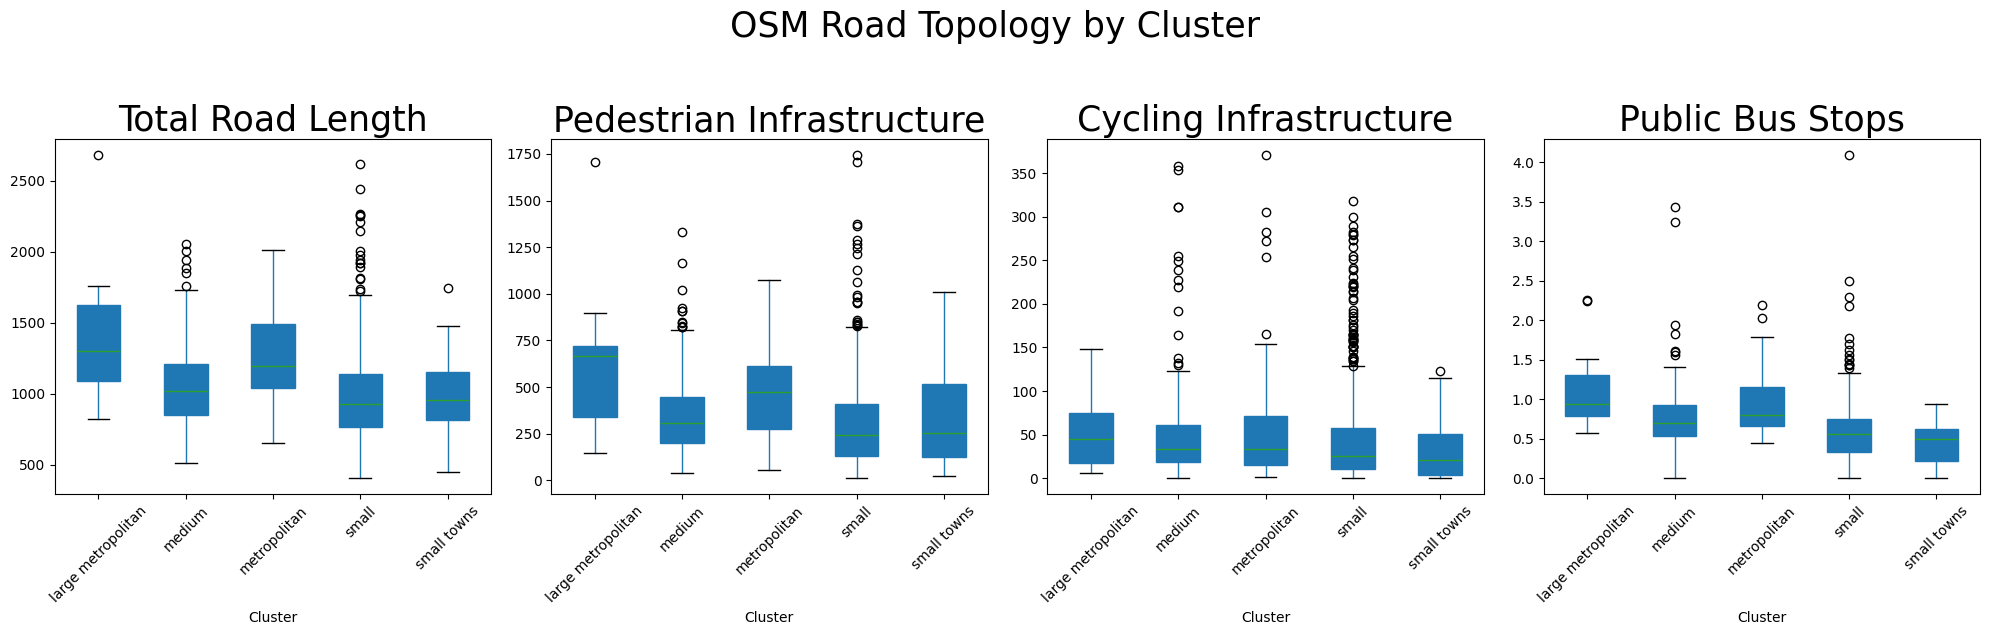

In [26]:
# Create figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Create individual boxplots
metrics = ['total_roadlength', 'pedestrian_cc', 'cycleway', 'pubtrans']
plot_titles = ['Total Road Length', 'Pedestrian Infrastructure', 'Cycling Infrastructure', 'Public Bus Stops']

for idx, (metric, title) in enumerate(zip(metrics, plot_titles)):
    transport.boxplot(
        column=metric,
        by='cluster',
        ax=axes[idx],
        grid=False,
        patch_artist=True
    )
    
    # Set titles and labels
    axes[idx].set_title(title, fontsize=25)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('')
    
    # Rotate x-axis tick labels by 45 degrees
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust overall title
plt.suptitle('OSM Road Topology by Cluster', y=1.05, fontsize=25)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('plots\\data\\osm.png', bbox_inches='tight')

# Show plot
plt.show()


Environmental Quality

In [76]:
### Air pollution

# Read ap data for cities + London 
df_ap = pd.read_csv('DATA\\data0\\grid_ap.csv', encoding='latin-1', low_memory=False, index_col=0).sort_values(by=['gid'], ascending=True)
# Exclude cities 
df_ap = cities(df_ap)
df_ap = cities2(df_ap)
# Exclude cities with 'K' as the penultimate letter except for the city of London
df_ap = df_ap[~(df_ap['urau_code'].apply(lambda x: x[-2] == 'K') & (df_ap['urau_code'] != 'UK001K2'))]
# Merge with population data
df_pop = pd.read_csv('DATA\\data\grid_pop.csv').sort_values(by=['gid'], ascending=True) 
df2 = df_ap[['gid', 'urau_code','PMmean','NO2mean']].merge(df_pop[['gid','urau_code','urau_name','pop_final','cluster']], on=['gid','urau_code'], how='inner')
# Remove rows with missing values
df2.dropna(subset=['NO2mean'], inplace=True)
df2.to_csv('DATA\\data\df_ap.csv',index = False)

# Save PM2.5 data
df_pm = df2[['gid', 'urau_code', 'urau_name', 'pop_final', 'PMmean','cluster']]
df_pm.rename(columns={'PMmean': 'val_grid'}, inplace=True)
df_pm.to_csv('DATA\\data\df_pm.csv',index = False)

# Save NO2 data
df_no2 = df2[['gid', 'urau_code', 'urau_name', 'pop_final', 'NO2mean','cluster']]
df_no2.rename(columns={'NO2mean': 'val_grid'}, inplace=True)
df_no2.to_csv('DATA\\data\df_no2.csv',index = False)

C:\Users\fmontana\AppData\Local\Temp\ipykernel_10948\1828761130.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm.rename(columns={'PMmean': 'val_grid'}, inplace=True)
C:\Users\fmontana\AppData\Local\Temp\ipykernel_10948\1828761130.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no2.rename(columns={'NO2mean': 'val_grid'}, inplace=True)


In [90]:
### Sourrounding Greeness (NDVI)

# Read NDVI data 
df_ndvi = pd.read_csv(os.path.join(working_directory, 'DATA', 'data0', 'df_ndvi.csv'))

# Merge with population data
df_pop = pd.read_csv(os.path.join(working_directory, 'DATA', 'data', 'grid_pop.csv'))
df_ndvi = pd.merge(df_ndvi, df_pop[['gid', 'urau_code', 'urau_name', 'pop_final','cluster']], on=['gid', 'urau_code'], how='inner')
df_ndvi.dropna(subset=['ndvi300_noriver'], inplace=True)
df_ndvi.rename(columns={'ndvi300_noriver': 'val_grid'}, inplace=True)
df_ndvi = df_ndvi[['gid', 'urau_code', 'urau_name', 'pop_final', 'val_grid','cluster']]
# Save the result to a new CSV file
df_ndvi.to_csv(os.path.join(working_directory, 'DATA', 'data', 'df_ndvi.csv'), index=False)

In [88]:
# Read NDVI target for London
df1 = pd.read_excel('DATA\\data0\\evelise_tabla.xlsx', sheet_name='Page 2 (NDVI)')
df1['City Category'] = df1['City Code'].str[-2]
df1 = df1[~((df1['City Category'] == 'K') & (df1['City Name'] != 'London (Greater city)'))]
df1 = df1[['City Code', 'Population below target NDVI (%)', 'Target NDVI (threshold)']]
df1.rename(columns={'City Code': 'urau_code'}, inplace=True)

# Read NDVI targe for cities
df2 = pd.read_excel('DATA\\data0\\evelise_tabla_cities.xls', sheet_name='ciudades ya incluidas')
df2 = df2[['City Code', '% of Population below target NDVI', 'Target NDVI (threshold)']]
df2.rename(columns={'City Code': 'urau_code', '% of Population below target NDVI': 'Population below target NDVI (%)'}, inplace=True)

# Combine the two dataframes
df = pd.concat([df1, df2], ignore_index=True)

# Apply custom functions to the combined dataframe
df = cities(df)
df = cities2(df)

# Calculate the population above the target NDVI
df['pop_ndvi'] = 100 - df['Population below target NDVI (%)']
df.rename(columns={'Target NDVI (threshold)': 'target_ndvi'}, inplace=True)

# Save the result to a new CSV file
df.to_csv('DATA\\data\\df_ndvi_target_tabla.csv', index=False)

In [95]:
### Lower Urban Heat Islands (UHI)

# Read UHI data for cities (excluding cities belonging to greater London)
uhi = pd.read_csv('DATA\\data0\\UHI_all_v2.csv')

# Calculate Canopy Urban Heat Island (CUHI) maximum
uhi["CUHI_max"] = uhi["AT_max"] - uhi["AT_max_SUE"]

# Select variables of interest
uhi = uhi[["gid", "urau_code", "CUHI_max"]]
uhi = cities2(uhi)

# Read population data and merge with UHI data
df_pop = pd.read_csv('DATA\\data\grid_pop.csv').sort_values(by=['gid'], ascending=True) 
dfc = uhi.merge(df_pop[['gid','urau_code','pop_final','urau_name','cluster']], on=['gid','urau_code'], how='inner')

# Read UHI data for London cities
dfl = pd.read_csv('DATA\\data0\All_UHI_London.csv')

# Calculate CUHI for London
dfl["CUHI_max"] = dfl["AT_max"] - dfl["AT_max_SUE"]

# Select variables of interest for London cities
df_london_cities = dfl[["gid", "urau_code", "CUHI_max"]]

# Read population data for London cities
df_pop0 = pd.read_csv('DATA\\data0\grid_pop_weigthed.csv', sep=";", encoding= 'unicode_escape') 
df_pop0['pop_final'] = df_pop0['pop_final'].str.replace(',', '.')
df_pop0['pop_final'] = pd.to_numeric(df_pop0['pop_final'])

# Select London cities
from utility import london_cities
df_pop0 = df_pop0[df_pop0['urau_code'].isin(london_cities)]
df_pop = df_pop0[df_pop0.pop_final!=0]

# Merge UHI data with population data for London cities
df_london_cities2 = pd.merge(df_london_cities, df_pop, on= ['gid','urau_code']) 
df_london_cities2['urau_code'] = 'UK001K2'
df_london_cities2['urau_name'] = 'London'
df_london_cities2['cluster'] = 'large metropolitan'

# Combine UHI data for all cities and London
df_uhi = pd.concat([dfc, df_london_cities2])

# Drop missing values
df_uhi = df_uhi.dropna(subset=['CUHI_max'])
df_uhi.rename(columns={'CUHI_max': 'val_grid'}, inplace=True)

# Save the combined UHI data to a CSV file
df_uhi.to_csv('DATA\\data\df_uhi.csv', index = False)

C:\Users\fmontana\AppData\Local\Temp\ipykernel_10948\1530147237.py:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  uhi = pd.read_csv('DATA\\data0\\UHI_all_v2.csv')


Green Spaces Accessibility

In [179]:
## Universal Access to Green Spaces

# Read the data
val = 'green_300_m'
folder_path = fr'DATA\data\{val}'

# Create an empty list to store the DataFrames
dfs = []
# List all files in the folder
files = os.listdir(folder_path)
# Iterate through the joblib files and load each one
for file in files:
    file_path = os.path.join(folder_path, file)

    # Load the file using joblib.load
    data = joblib.load(file_path)
    dfs.append(data)
df = pd.concat(dfs, ignore_index=True)

df2 = df.copy()
df2['log_values'] = np.log1p(df2['new_val']) 
dd1 = cities(df2)
dd1 = cities2(dd1)
dd1 = new_name(dd1)
dd1 = dd1.drop(columns=['urau_name'])
gdf2 = pd.merge(gdf1[['geometry','cluster','urau_name']], dd1, on='geometry', how='inner')
gdf2 = gdf2.rename(columns={'log_values': 'val_grid', 'new_target_pop': 'target_pop'})
gdf2 = gdf2[['gid','urau_code','urau_name','cluster','val_grid','target_pop']]
gdf2.to_csv('DATA\\data\\df_300m.csv', index = False)

In [180]:
## Access to large green spaces

# Read the data
val = 'green_2_km'
folder_path = fr'DATA\data\{val}'

# Create an empty list to store the DataFrames
dfs = []
# List all files in the folder
files = os.listdir(folder_path)
# Iterate through the joblib files and load each one
for file in files:
    file_path = os.path.join(folder_path, file)

    # Load the file using joblib.load
    data = joblib.load(file_path)
    dfs.append(data)
df = pd.concat(dfs, ignore_index=True)

df2 = df.copy()
df2['log_values'] = np.log1p(df2['new_val']) 
dd1 = cities(df2)
dd1 = cities2(dd1)
dd1 = new_name(dd1)
dd1 = dd1.drop(columns=['urau_name'])
gdf2 = pd.merge(gdf1[['geometry','cluster','urau_name']], dd1, on='geometry', how='inner')
gdf2 = gdf2.rename(columns={'log_values': 'val_grid', 'new_target_pop': 'target_pop'})
gdf2 = gdf2[['gid','urau_code','urau_name','cluster','val_grid','target_pop']]
gdf2.to_csv('DATA\\data\\df_2km.csv', index = False)